In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/email-spam-detection-dataset-classification/spam.csv


In [2]:
df = pd.read_csv("/kaggle/input/email-spam-detection-dataset-classification/spam.csv", encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
df.describe(include=['object'])

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [5]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [6]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix

In [8]:
df = df.rename(columns={'v1': 'Category', 'v2': 'Text'})
df.head()

,Category,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df['Category'].unique()

array(['ham', 'spam'], dtype=object)

In [10]:
df['Category'] = df['Category'].map({'ham':0,'spam':1})
df.head()

,Category,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
nltk.download('stopwords')
nltk.download('punkt')

stop_words =set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

df['cleaned_text'] = df['Text'].apply(preprocess_text)

df.head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Category,Text,cleaned_text
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though


In [12]:
count = CountVectorizer()
text = count.fit_transform(df['cleaned_text'])

In [13]:
x_train, x_test, y_train, y_test = train_test_split(text, df['Category'], test_size=0.30, random_state=42)

In [14]:
mlp_classifier_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)
mlp_classifier_model.fit(x_train, y_train)
mlp_pred = mlp_classifier_model.predict(x_test)

In [15]:
multinomial_nb_model = MultinomialNB()
multinomial_nb_model.fit(x_train, y_train)
multinomial_pred = multinomial_nb_model.predict(x_test)

In [16]:
bernoulli_nb_model = BernoulliNB()
bernoulli_nb_model.fit(x_train, y_train)
bernoulli_pred = bernoulli_nb_model.predict(x_test)

In [17]:
def evaluate_model(name, y_true, y_pred):
    print(f"{name}")
    print(f"Accuracy score: {accuracy_score(y_true, y_pred):.2f}")
    print(f"Precision score: {precision_score(y_true, y_pred):.2f}")
    print(f"Recall score: {recall_score(y_true, y_pred):.2f}")
    print(f"F1 score: {f1_score(y_true, y_pred):.2f}\n")

In [18]:
evaluate_model("MLP Classifier", y_test, mlp_pred)
evaluate_model("Multinomial NB", y_test, multinomial_pred)
evaluate_model("Bernoulli NB", y_test, bernoulli_pred)

MLP Classifier
Accuracy score: 0.98
Precision score: 0.99
Recall score: 0.85
F1 score: 0.91

Multinomial NB
Accuracy score: 0.97
Precision score: 0.86
Recall score: 0.91
F1 score: 0.88

Bernoulli NB
Accuracy score: 0.97
Precision score: 0.97
Recall score: 0.79
F1 score: 0.87



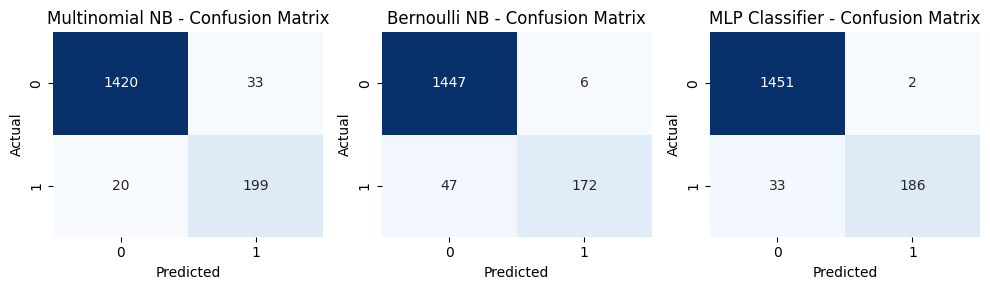

In [19]:
models = [("Multinomial NB", multinomial_nb_model), ("Bernoulli NB", bernoulli_nb_model), ("MLP Classifier", mlp_classifier_model)]
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i, (model_name, model) in enumerate(models):
    cm = confusion_matrix(y_test, model.predict(x_test))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])
    axes[i].set_title(f"{model_name} - Confusion Matrix")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")
plt.tight_layout()
plt.show()

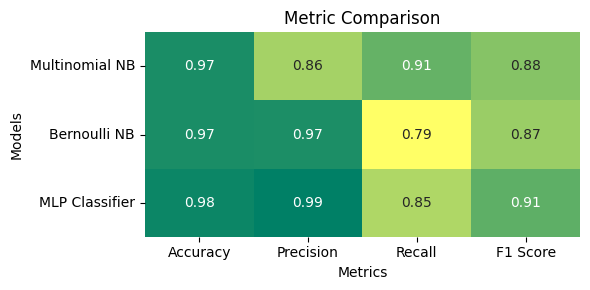

In [20]:
metric_data = []
for model_name, model in models:
    pred = model.predict(x_test)
    metric_data.append([accuracy_score(y_test, pred), precision_score(y_test, pred), recall_score(y_test, pred), f1_score(y_test, pred)])

plt.figure(figsize=(6, 3))
sns.heatmap(metric_data, annot=True, fmt=".2f", cbar=False, cmap="summer_r", xticklabels=["Accuracy", "Precision", "Recall", "F1 Score"], yticklabels=[model_name for model_name, _ in models])
plt.title("Metric Comparison")
plt.yticks(rotation=0)
plt.xlabel("Metrics")
plt.ylabel("Models")
plt.tight_layout()
plt.show()

In [21]:
df.to_csv("spam_detection.csv")